In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
def getData():
    data = pd.read_csv("~/Desktop/NCSA_genomics/onePersonData.txt", sep="\t")
    data.head()
    #df["Display Time"]
    return data

In [3]:
df = getData()
df.head()
#df.shape


,Display Time,GlucoseValue,subjectId,Internal Time
0,2014-02-03 03:42:12,93,1636-69-001,2016-02-03 00:05:23
1,2014-02-03 03:47:12,93,1636-69-001,2016-02-03 00:10:23
2,2014-02-03 03:52:12,93,1636-69-001,2016-02-03 00:15:23
3,2014-02-03 03:57:12,95,1636-69-001,2016-02-03 00:20:23
4,2014-02-03 04:02:12,96,1636-69-001,2016-02-03 00:25:23


In [4]:
tf.random.set_seed(1234)
TRAIN_SPLIT = 1500


In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [6]:
uni_data = df['GlucoseValue']
uni_data.index = df['Display Time']
uni_data.head()

Display Time
2014-02-03 03:42:12    93
2014-02-03 03:47:12    93
2014-02-03 03:52:12    93
2014-02-03 03:57:12    95
2014-02-03 04:02:12    96
Name: GlucoseValue, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x145b85d50>],
      dtype=object)

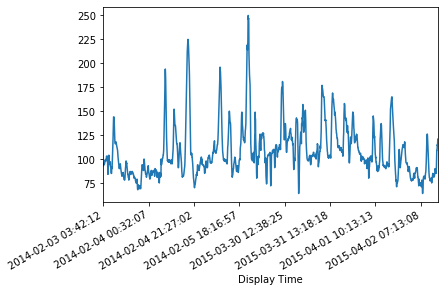

In [7]:
uni_data.plot(subplots=True)

In [8]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [9]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [10]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.6467603 ]
 [-0.6467603 ]
 [-0.6467603 ]
 [-0.5752503 ]
 [-0.5394953 ]
 [-0.5752503 ]
 [-0.5752503 ]
 [-0.5752503 ]
 [-0.5394953 ]
 [-0.5037403 ]
 [-0.43223029]
 [-0.43223029]
 [-0.46798529]
 [-0.43223029]
 [-0.46798529]
 [-0.46798529]
 [-0.39647529]
 [-0.39647529]
 [-0.28921029]
 [-0.28921029]
 [-0.28921029]
 [-0.28921029]
 [-0.28921029]
 [-0.28921029]
 [-0.5037403 ]
 [-0.82553531]
 [-0.96855531]
 [-0.78978031]
 [-0.5394953 ]
 [-0.5394953 ]]

 Target temperature to predict
-0.3607202906082465


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

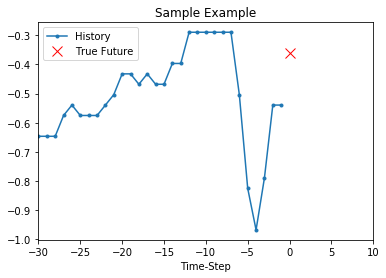

In [11]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [12]:
BATCH_SIZE = 1
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [13]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(7, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [14]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(1, 1)


In [15]:
EVALUATION_INTERVAL = 1500
EPOCHS = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, verbose=1)
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=300,callbacks=[early_stop])

Train for 1500 steps, validate for 300 steps
Epoch 1/50
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2735 - val_loss: 0.1146
Epoch 2/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.1268 - val_loss: 0.0898
Epoch 3/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0968 - val_loss: 0.0613
Epoch 4/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0867 - val_loss: 0.0669
Epoch 5/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0831 - val_loss: 0.0581
Epoch 6/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0834 - val_loss: 0.0547
Epoch 7/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0821 - val_loss: 0.0528
Epoch 8/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0827 - val_loss: 0.0588
Epoch 9/50
1500/1500 [==============================] - 22s 15ms/step - loss: 0.0790 - val_loss: 0.0552
Epoch 10/50
1500/15

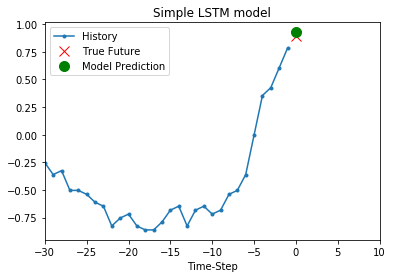

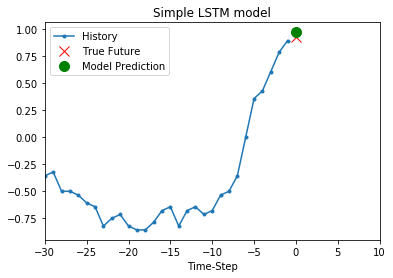

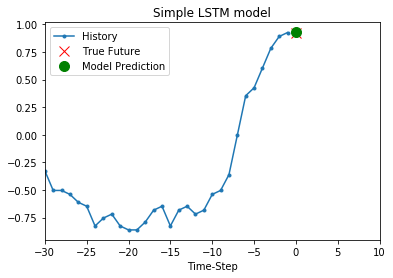

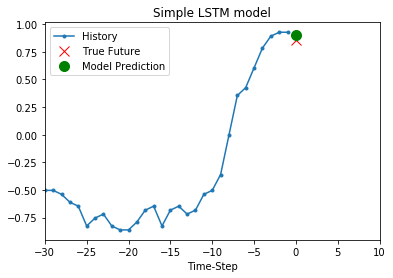

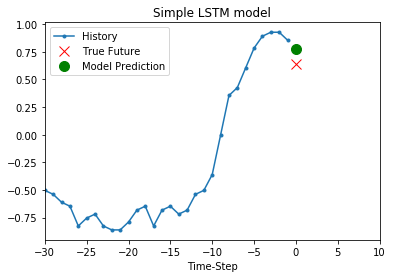

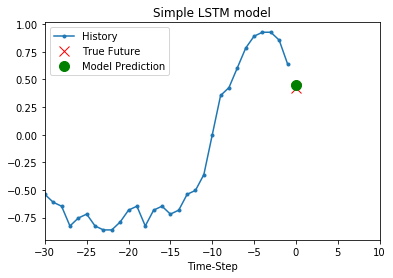

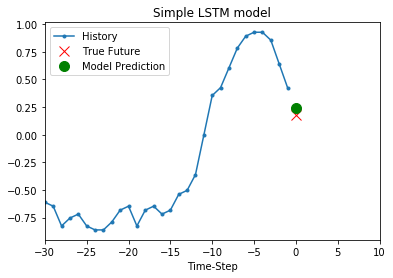

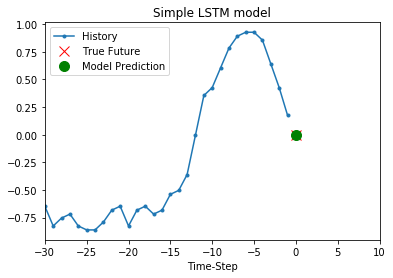

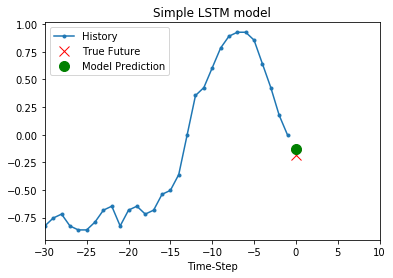

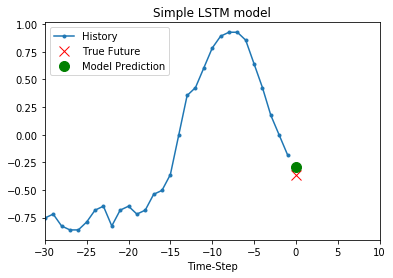

In [16]:
for x, y in val_univariate.take(10):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [17]:
comp_data = df['GlucoseValue']
comp_data = comp_data.values
comp_mean = comp_data[TRAIN_SPLIT:].mean()
comp_std = comp_data[TRAIN_SPLIT:].std()
comp_data = (comp_data-comp_mean)/comp_std
comp_data = comp_data[TRAIN_SPLIT:]
comp_data

array([ 0.41134292,  0.26030863,  0.31065339,  0.05892957,  0.05892957,
        0.0085848 , -0.09210473, -0.1424495 , -0.39417332, -0.29348379,
       -0.24313903, -0.39417332, -0.44451809, -0.44451809, -0.34382856,
       -0.19279426, -0.1424495 , -0.39417332, -0.19279426, -0.1424495 ,
       -0.24313903, -0.19279426,  0.0085848 ,  0.05892957,  0.26030863,
        0.76375628,  1.26720394,  1.36789347,  1.6196173 ,  1.87134112,
        2.02237542,  2.07272018,  2.07272018,  1.97203065,  1.66996206,
        1.36789347,  1.01548011,  0.76375628,  0.51203246,  0.26030863,
        0.10927433,  0.05892957, -0.04175996, -0.1424495 , -0.09210473,
       -0.09210473, -0.19279426, -0.1424495 , -0.1424495 , -0.19279426,
       -0.19279426, -0.1424495 , -0.19279426, -0.19279426, -0.19279426,
       -0.24313903, -0.29348379, -0.29348379, -0.29348379, -0.19279426,
       -0.1424495 , -0.09210473,  0.0085848 ,  0.05892957,  0.05892957,
        0.0085848 , -0.04175996, -0.04175996, -0.04175996, -0.09

In [26]:
predicted_values = list()
for x,y in val_univariate.take(346):
    predicted_values.append(simple_lstm_model.predict(x)[0].tolist())

#print(predicted_values)

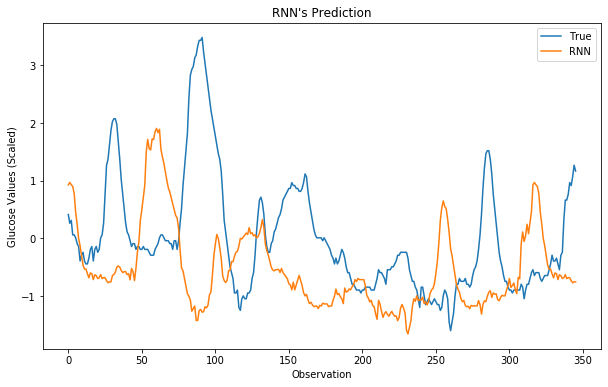

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(comp_data, label='True')
plt.plot(predicted_values, label='RNN')
plt.title("RNN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Glucose Values (Scaled)')
plt.legend()
plt.show();

In [51]:
#inversing the scaling
new_values = (comp_data*comp_std)+comp_mean
#predicted_values = predicted_values.tolist()
new_predicted_values = list()
for i in range(346):
    new_predicted_values.append((predicted_values[i][0]*comp_std)+comp_mean)


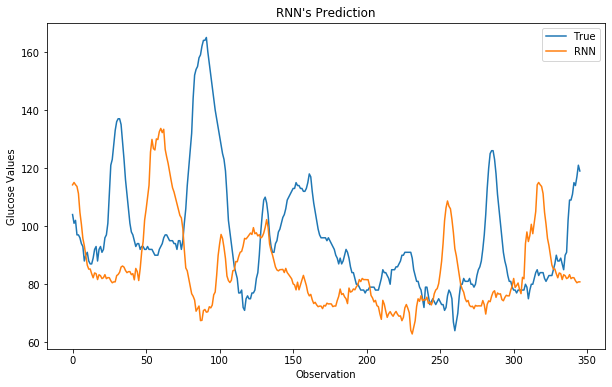

In [52]:
#replot
plt.figure(figsize=(10, 6))
plt.plot(new_values, label='True')
plt.plot(new_predicted_values, label='RNN')
plt.title("RNN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Glucose Values')
plt.legend()
plt.show();